# Project task 02: Hidden Markov Model

In [1]:
import numpy as np
import scipy.sparse as sp
import re
import json
import time
import math
from scipy.sparse import linalg as spl
from collections import defaultdict
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

## 1. Introduction


In this proejct task, we use hidden markov models (HMMs) as a probabilistic generative model for text data. Intuitively, we can think of each latent variable $Z_t \in \lbrace 1,...,K \rbrace$ as, e.g., a hidden part-of-speech tag (like noun, verb, or adjective). Each observation $X_t\in \lbrace 1,...,V \rbrace$ is a word. $K$ denotes number of possible states and $V$ denotes the number of words in our vocabulary. The model generates a sequence of words (i.e. a sentence) as follows:
* Generate $Z_1$ from the initial probability distribution ${\pi} \in \mathbb{R}^K$:
\begin{equation}
Pr(Z_1=k) = \mathbf{\pi}_k.
\end{equation}
* Given $Z_1$, generate $Z_2,Z_3,...,Z_t$ as :
\begin{equation}
Pr(Z_{t+1}=j|Z_t=i) = \mathbf{A}_{ij},
\end{equation}
where $\mathbf{A} \in \mathbb{R}^{K\times K}$ is the state transition probability matrix.

* Given $Z_t$, generate $X_t$ as :
\begin{equation}
Pr(X_{t}=v|Z_t=i) = \mathbf{B}_{iv},
\end{equation}


Indeed, given a parameter set $\lbrace \mathbf{A},\mathbf{B},\pi \rbrace$ we can generate a set of sentences. Of course the set can contain sentences of different sizes.   

Your task is to classify a given sentence as either 1-star or 5-star. For this task, roughly we consider the following procedure:
* We select a subset of 1-star (resp. 5-star) reviews as training set. (will be stored in variables `reviews_1star_train` (resp. `reviews_5star_train`))  
* We learn **two** HMMs: HMM $\mathcal{H}_1$ on `reviews_1star_train` and HMM $\mathcal{H}_5$ on `reviews_5star_train`.
* In test phase, we classify a sentence based on the likelihood of the sentence in $\mathcal{H}_1$ and $\mathcal{H}_5$ and class probability of 1-star and 5-star reviews.

The above steps are elaborated upon in Section 3.

## 2. Load data

We'll be working with a subset of reviews for restaurants in Las Vegas. The reviews that we'll be working with are either 1-star or 5-star. 
You can download the used data set (`task03_data.npy`) from:

* ([download link](https://syncandshare.lrz.de/dl/fi7cjApuE3Bd3xyfsyx3k9jr/task03_data.npy)) the preprocessed set of 1-star and 5-star reviews 

In [2]:
data = np.load("task03_data.npy")
reviews_1star = data.item()["reviews_1star"]
reviews_5star = data.item()["reviews_5star"]

The variable `reviews_1star` (resp. `reviews_5star`) is a list of sentences of 1-star (resp. 5-star) reviews. Each sentence is itself a list of words.

We can inspect how the sentences look like:

In [3]:
print("a 1-star review: " + str(reviews_1star[1]))
print("a 5-star review: " + str(reviews_5star[1]))

a 1-star review: ['This', 'place', 'tops', 'the', 'least', 'favorite', 'list', 'by', 'a', 'long', 'shot']
a 5-star review: ['Filet', 'mignon', 'and', 'lobster', 'tail', 'was', 'very', 'good']


## 3. Implementaion

A set of sentences are assumed to be generated from an HMM $\mathcal{H}$ as explained in introduction.
We denote parameters of $\mathcal{H}$ by $\lbrace \mathbf{A},\mathbf{B},\pi \rbrace$. Given the set of sentences, your task is to learn the unknown parameters $\lbrace \mathbf{A},\mathbf{B},\pi \rbrace$ via EM algorithm for HMMs, i.e.,  Baum-Welch algorithm.


We provide a helper class `HMM_Params` that contains three randomly-initialized stochastic matrices $\mathbf{A}\in \mathbb{R}^{K\times K}$, $\mathbf{B}\in \mathbb{R}^{K\times V}$, and $\pi \in \mathbb{R}^{K\times 1}$.

In [4]:
class HMM_Params:
    
    def __init__(self,n_states,n_symbols):
        """ Makes three randomly initialized stochastic matrices `self.A`, `self.B`, `self.pi`.
        
        Parameters
        ----------
        n_states: int
                  number of possible values for Z_t.
        n_symbols: int
                  number of possible values for X_t.
                  
        Returns
        -------
        None
        
        """
        self.A  = self.rnd_stochastic_mat(n_states,n_states)
        self.B  = self.rnd_stochastic_mat(n_states,n_symbols)
        self.pi = self.rnd_stochastic_mat(1,n_states).transpose()
    def rnd_stochastic_mat(self,I,J):
        """ Retruns a randomly initialized stochastic matrix with shape (I,J).
        
        Parameters
        ----------
        I: int
           shape[0] of desired matrix.
        J: int
           shape[1] of disired matrix.
                  
        Returns
        -------
        x: np.ndarray
           a rondom stochastic matrix with shape (I,J)
        
        """
        x = np.full((I,J),(1/J))
        x = x + (np.random.randn(I,J)*(1.0/(J*J)))
        x = x/np.reshape(np.sum(x,axis=1),newshape=(I,1))
        return x

We provide a helper class `HMM_TxtGenerator`.
Complete the implementation of the following functions:
* `HMM_TxtGenerator.forwards_backwards(sentence_in)`
* `HMM_TxtGenerator.E_step(sentence_in)`
* `HMM_TxtGenerator.generate_sentence(sentence_length)`

For parameter describtions, please refer to the headers below. 

Note that `HMM_TxtGenerator` is a model which will be defined only on one curpos. We are going to make two instances of this class, one for 1-star reviews and one for 5-star reviews. 

In [5]:
class HMM_TxtGenerator:
    def __init__(self,corpus,K):
        """Given the set of sentences `corpus` and number of states `K`, builds an HMM.
           Firstly it makes the volcabulary `self.word_list` based on all present words in 
           `corpus`. The variable `self.word_list` is a list of words. Then index of the word
           `self.word_list[v]` is v. Moreover, this function constructs `self.model_params`
           which is an instance of randomly initialized `HMM_Params`.
    
        Parameters
        ----------
        corpus : A list of sentences. Each sentence is a list of words.  
            We will learn model_params using sentences in `corpus`.
        K: int
           Number of possible states, i.e. Z_t \in {0,...,K-1}
        
    
        Returns
        -------
        None :
        """
        self.corpus = corpus.copy()
        self.K = K
        #collect all words ---
        word_dic = {}
        for sent in self.corpus:
            for w in sent:
                if(w in word_dic):
                    word_dic[w] = word_dic[w] + 1
                else:
                    word_dic[w] = 1
        self.word_list = [u for u in word_dic.keys()]
        self.word_dic  = word_dic
        self.V = len(self.word_list)
        #init params
        self.model_params = HMM_Params(K,len(self.word_list))
    
    def forwards_backwards(self,sentence_in):
        """Does the forwards-backwards algorithm for an observed list of words
           (i.e. and observed sentence).
    
        Parameters
        ----------
        sentence_in : a list of T words. Each word is a string.
                      You can convert `sentence_in` to a sequence of word-indices
                      as `x = self.sentence_to_X(sentence_in)`. 
            
        Returns
        -------
        alpha : np.ndarray, shape=(T,K)
                alpha(t,k) = Pr(Z_t=k,x[1:t])
        beta  : np.ndarray, shape=(T,K)
                beta(t,k)  = Pr(X_{t+1:T}|Z_t=k)
        log_likelihood  : scalar
                log probability of evidence, Pr(X_{1:T}=sentence_in) 
        """
        
        ### YOUR CODE HERE ###
        
        A = self.model_params.A
        B = self.model_params.B
        pi = self.model_params.pi
        T = len(sentence_in)
        
        alpha = np.zeros((T, self.K))
        beta = np.zeros((T, self.K))
        
        x = self.sentence_to_X(sentence_in)
        
        # Forwards algorithm
        
        # initialisation
        pi = np.reshape(pi, (K)) 
        alpha[0, :] = np.multiply(pi, B[:, x[0]])
        
        # recursion
        for i in range(0,T-1,1):
            alpha[i+1, :] = np.multiply(B[:, x[i+1]], np.dot(alpha[i, :], A))
      
        # Backwards algorithm
        # initialisation
        beta[T-1, :] = np.ones(K)
        # recursion
        for i in range(T-2, -1, -1):
            beta[i, :] = np.dot(A, np.multiply(B[:, x[i+1]], beta[i+1, :]))
           
        # log likelihood = sum over s of alpha(t, s)*beta(t, s)
        log_likelihood = np.sum(np.multiply(alpha,beta), axis=1)


        log_likelihood = np.log(log_likelihood[0])

        return alpha, beta, log_likelihood
        
    
    def E_step(self,sentence_in):
        """Given one observed `sentence_in`, computes sum_chi(i,j), sum_gamma_x(i,j), gamma_1(k).
           The notations correspond to numerator of lecture slide 67.
           Hint: You can begin by computing alpha and beta as
                    `forwards_backwards(self,sentence_in)`
        
        Parameters
        ----------
        sentence_in : a list of T words. Each word is a string.
                      You can convert sentence_in to a sequence of word-indices
                      as `x = self.sentence_to_X(sentence_in)`. 
            
        Returns
        -------
        sum_chi : np.ndarray, shape=(K,K)
             Contains values for sum_chi(i,j), numerator of A(i,j) update on slide 67
        sum_gamma_x : np.ndarray, shape=(K,V)
             Contains values for sum_gamma_x(i,j), numerator of B(i,j) update on slide 67
        gamma_1 : np.ndarray, shape=(K,1)
             Contains values for gamma_1(k), Pi(k) update on slide 67.
        """
        
        ### YOUR CODE HERE ###
        A = self.model_params.A
        B = self.model_params.B
        
        alpha, beta, log_likelihood = self.forwards_backwards(sentence_in)
        conv_sen = self.sentence_to_X(sentence_in)
        T = len(conv_sen)
        gamma_x = np.multiply(alpha,beta)
        gamma_x = gamma_x / np.sum(gamma_x , axis=1, keepdims=True)
       
        
        sum_gamma_x = np.zeros((self.K, self.V))
        #this is not vectorized :( #
        for i in range(self.K):
            for j in range(self.V):
                for t in range(T):
                    if(j == conv_sen[t]):
                        sum_gamma_x[i,j] += gamma_x[t,i]
 
        
        chi = np.zeros((T-1,self.K, self.K))
        
        for t in range(T-1):
            for i in range(self.K):
                chi[t,i,:] = alpha[t,i] * A[i,:] * beta[t +1,:] * B[:,conv_sen[t+1]]
        #for i in range(self.K):     
         #   chi[T-1,i,:] = alpha[T-1,i] * A[i,:] 
        
                    
        ##chi =np.dot( np.dot(alpha,self.model_params.A), np.dot() )
       

        marg_chies = np.sum(np.sum(chi,axis=2, keepdims=True), keepdims=True, axis=1)
        chi = chi / marg_chies
        sum_chi = np.sum(chi,axis=0)
        gamma_1  = np.reshape(gamma_x[0,:],(K,1))
        return sum_chi, sum_gamma_x, gamma_1
    
    def generate_sentence(self,sentence_length):
        """ Given the model parameter,generates an observed
            sequence of length `sentence_length`.
            Hint: after generating a list of word-indices like `x`, you can convert it to
                  an actual sentence as `self.X_to_sentence(x)`
            
        Parameters
        ----------
        sentence_length : int,
                        length of the generated sentence.
            
        Returns
        -------
        sent : a list of words, like ['the' , 'food' , 'was' , 'good'] 
               a sentence generated from the model.
        """
        
        ### YOUR CODE HERE ###
        
    
    def X_to_sentence(self,input_x):
        """Convert a list of word-indices to an actual sentence (i.e. a list of words).
           To convert a word-index to an actual word, it looks at `self.word_list`.
           
    
        Parameters
        ----------
        input_x : a list of integer
                  list of word-indices, like [0,6,1,3,2,...,1]
        
    
        Returns
        -------
        sent : a list of words like ['the', 'food', 'was', 'good']
        """
        sent = []
        V = len(self.word_list)
        for u in input_x:
            if(u<V):
                sent.append(self.word_list[u])
            else:
                raise Exception("values of input_x have to be in " +\
                                str([0,V-1])  + ", but got the value " + str(u) + ".")
        return sent
    
    def sentence_to_X(self,input_sentence):
        """Convert a sentence (i.e. a list of words) to a list of word-indices.
           Index of the word `w` is `self.word_list.index(w)`.
           
    
        Parameters
        ----------
        input_sentence : list
                         a list of words like ['the', 'food', 'was', 'good']
        
        Returns
        -------
        X : list
            a list of word-indices like [50,4,3,20]
        """
        X = []
        for w in input_sentence:
            X.append(self.word_list.index(w))
        return X
    
    def is_in_vocab(self,sentence_in):
        """Checks if all words in sentence_in are in vocabulary.
           If `sentence_in` contains a word like `w` which is not in `self.word_list`,
           it means that we've not seen word `w` in training set (i.e. `curpus`).
           
    
        Parameters
        ----------
        sentence_in : list
                      a list of words like ['the', 'food', 'was', 'good']
        
        Returns
        -------
        to_ret : boolean
            [We've seen all words in `sentence_in` when training model-params.]
        """
        to_return = True
        for w in sentence_in:
            if(w not in self.word_list):
                to_return = False
        return to_return
    
    def update_params(self):
        """ One update procedure of the EM algorithm.
            - E-step: For each sentence like `sent` in corpus, it firstly computes gammas and chis. 
                    Then, it sums them up to obtain numerators for M-step (slide 67).
            - M-step: normalize values obtain in E-step and assign new values to A, B, pi.
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        """
        #E-step
        K = self.K
        V = self.V
        corpus_sum_chi , corpus_sum_gamma_x , corpus_gamma_1 = np.zeros([K,K]),np.zeros([K,V]),np.zeros([K,1])
        for sent in self.corpus:
            sent_sum_chi, sent_sum_gamma_x, sent_gamma_1 = self.E_step(sent)
            corpus_sum_chi += sent_sum_chi
            corpus_sum_gamma_x += sent_sum_gamma_x
            corpus_gamma_1 += sent_gamma_1
        #M-step
        A_new  = corpus_sum_chi / np.reshape(np.sum(corpus_sum_chi,axis=1),newshape=(K,1))
        B_new  = corpus_sum_gamma_x / np.reshape(np.sum(corpus_sum_gamma_x,axis=1),newshape=(K,1))
        pi_new = corpus_gamma_1 / np.sum(corpus_gamma_1)
        self.model_params.A = A_new
        self.model_params.B = B_new
        self.model_params.pi = pi_new
    
    def learn_params(self,num_iter):
        """ Runs update procedures of the EM-algorithm for `num_iter` iterations.
        
        Parameters
        ----------
        num_iter: int
                  number of iterations.
        
        Returns
        -------
        history_loglik: list of floats
                `history_loglik[t]` is log-probability of training data in iteration `t`.
        """
        history_loglik = []
        for counter in range(num_iter):
            print("iteration " + str(counter) +\
                  " of " + str(num_iter) , end="\r")
            history_loglik.append(self.loglik_corpus())
            self.update_params()
        return history_loglik
    
    def loglik_corpus(self):
        """ Computes log-likelihood of the corpus based on current parameters.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        loglik: float
                log-likelihood of the corpus based on current parameters.
        
        """
        loglik = 0
        for sent in self.corpus:
            _,_,loglik_of_sent = self.forwards_backwards(sent)
            loglik += loglik_of_sent
        return loglik
    
    def loglik_sentence(self,sentence_in):
        """ Computes log-likelihood of `sentence_in` based on current parameters.
        
        Parameters
        ----------
        sentence_in: a list of words
        
        Returns
        -------
        loglik_of_sent: float
                        log-likelihood of `sentence_in` based on current parameters.
        """
        #check if all words are in corpus.
        for w in sentence_in:
            if(w not in self.word_list):
                return -np.Inf
        _,_,loglik_of_sent = self.forwards_backwards(sentence_in)
        return loglik_of_sent

We split each set of reviews (i.e. `reviews_1star` and `reviews_5star`) into training/test sets.
You can change percentage of train/test instances by setting `train_percentage`.

In [6]:
train_percentage = 80
def split_to_traintest(in_list,percentage):
    n_train = math.floor(len(in_list)*percentage/100)
    n_test  = len(in_list) - n_train
    return in_list[0:n_train],in_list[n_train:]
reviews_1star_train , reviews_1star_test = split_to_traintest(reviews_1star,train_percentage)
reviews_5star_train , reviews_5star_test = split_to_traintest(reviews_5star,train_percentage)
reviews_test = reviews_1star_test + reviews_5star_test
y_test  = [1 for i in range(len(reviews_1star_test))] + \
          [5 for i in range(len(reviews_5star_test))]

We assume that 1-star reviews and 5-star reviews are generated from two different HMMs.
Therefore, we define two HMMs `hmm_1star` and `hmm_5star` and we learn their parameters using the sets `reviews_1star_train` and `reviews_5star_train`, respectively.

Firstly let's define two HMMs. `K` is the number of possible hidden states. Here we set it maually to a constant.

In [7]:
K = 8
hmm_1 = HMM_TxtGenerator(reviews_1star_train,K)
hmm_5 = HMM_TxtGenerator(reviews_5star_train,K)

In [8]:
'''
a, b, ll = hmm_1.forwards_backwards(["the", "food", "is", "good"])
print("Alpha")
print(a)
print("Beta")
print(b)
print("log likelihood")
print(ll)
'''

'\na, b, ll = hmm_1.forwards_backwards(["the", "food", "is", "good"])\nprint("Alpha")\nprint(a)\nprint("Beta")\nprint(b)\nprint("log likelihood")\nprint(ll)\n'

Now we fit the HMMs to their corresponding training sets using expectation–maximization (EM) algorithm.

The function `HMM_TxtGenerator.learn_params(num_iter)` repeats EM steps for some iterations, and returns the history of log-likelihood during the steps.
At the following, we repeat EM updates for `n_iter` iterations and plot the history of log-likelihood. When log-probability of evidence stops increasing, it means that we can quit EM updates. Please note that log-likelihood might increase dramatically in first iterations. Therefore, in the plot the amount of increase in final iterations would look small. 

You can increase/decrease the number of iterations by setting `n_iter`.

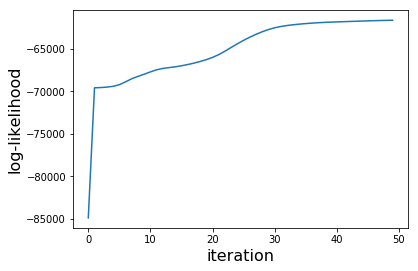

In [9]:
n_iter = 50
history_loglik_1 = hmm_1.learn_params(n_iter)
plt.figure()
plt.plot(range(len(history_loglik_1)) , history_loglik_1)
plt.xlabel("iteration",fontsize=16)
plt.ylabel("log-likelihood",fontsize=16)
plt.show()

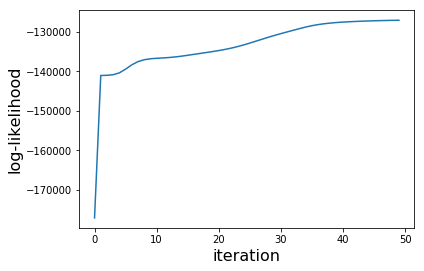

In [10]:
history_loglik_5 = hmm_5.learn_params(n_iter)
plt.figure()
plt.plot(range(len(history_loglik_5)) , history_loglik_5)
plt.xlabel("iteration",fontsize=16)
plt.ylabel("log-likelihood",fontsize=16)
plt.show()

Now we have learned the parameters $\pi_1,\mathbf{A}_1,\mathbf{B}_1$ and $\pi_5,\mathbf{A}_5,\mathbf{B}_5$. Assume that we have a sentence of length $T$ and we want to classify it as either 1-star or 5-star. For this task, we consider the following probabilistic model:

In [11]:
Image(filename ="task03_classification.png" , width=250)

FileNotFoundError: [Errno 2] No such file or directory: 'task03_classification.png'

In the above model, $Y\in \lbrace 1,5 \rbrace$ indicates the class of the review, either 1-star or 5-star. 

The generative process of the above model is as follows:
* Generate the class of the sentence:
\begin{equation}
Pr(Y=1) = p \;\;\;\;, \;\;\;\; Pr(Y=5) = 1-p \;\;.
\end{equation}
* If 1-star (resp. 5-star) category is chosen, generate the sentence from marginal distribution of HMM 1 (resp. 5):
\begin{equation}
Pr(X_{1:T} | Y) = 
\begin{cases}
Pr(X_{1:T}|\pi_1,\mathbf{A}_1,\mathbf{B}_1) \;\;\;\;\;\; Y=1 \\
Pr(X_{1:T}|\pi_5,\mathbf{A}_5,\mathbf{B}_5) \;\;\;\;\;\; Y=5
\end{cases}
\end{equation}

To classify a sentence $X_{1:T}$, we can simply compare $Pr(Y=1|X_{1:T})$ with $Pr(Y=5|X_{1:T})$. Using Bayes' theorem, we can make decision by computing the terms
$logPr(Y=1)+logPr(X_{1:T}|\pi_1,\mathbf{A}_1,\mathbf{B}_1)$ and $logPr(Y=5)+ logPr(X_{1:T}|\pi_5,\mathbf{A}_5,\mathbf{B}_5)$. More precisely:
* The terms $logPr(X_{1:T}|\pi_1,\mathbf{A}_1,\mathbf{B}_1)$ and $logPr(X_{1:T}|\pi_5,\mathbf{A}_5,\mathbf{B}_5)$ are provided by the functions `hmm_1.loglik_sentence` and `hmm_5.loglik_sentence`. 
* We can approximate $Pr(Y=1)$ and $Pr(Y=5)$ simply by computing the frequency of each class in the training set.

We assume that if a sentence contains a word which is **not** in the vocabulary of a model, likelihood of the sentence is zero and log-likelihood is $-\infty$. At the following, we drop the samples in test set which have $-\infty$ log-likelihood in both models. We store all other samples in `reviews_test_filtered` and their categories in `y_test_filtered`. 

In [ ]:
temp_reviews = []
temp_y = []
for counter in range(len(reviews_test)):
    current_review = reviews_test[counter]
    current_y   = y_test[counter]
    if(hmm_1.is_in_vocab(current_review) | hmm_5.is_in_vocab(current_review)):
        temp_reviews.append(current_review)
        temp_y.append(current_y)
reviews_test_filtered = temp_reviews
y_test_filtered = temp_y

Implement the function `classify_review` which is expalined at the following:

In [ ]:
def classify_review(hmm_1,hmm_5,p,sentence_in):
    """Given the trained models `hmm_1` and `hmm_2` and frequency of
       1-star reviews, classifies `sentence_in` 
    
    Parameters
    ----------
    hmm_1 : HMM_TxtGenerator
        The trained model on 1-star reviews.
    hmm_5 : HMM_TxtGenerator
        The trained model on 5-star reviews.
    p: a scalar in [0,1]
        frequency of 1-star reviews, (#1star)/(#1star + #5star)
    
    Returns
    -------
    c : int in {1,5}
        c=1 means sentence_in is classified as 1. 
        similarly c=5 means sentence_in is classified as 5.
        
    """
    
    ### YOUR CODE HERE ###
    

We evaluate our classifier on the test set.

In [ ]:
p = len(reviews_1star_train)/(len(reviews_1star_train)+len(reviews_5star_train))
y_pred = []
for sent in reviews_test_filtered:
    y_pred.append(classify_review(hmm_1,hmm_5,p,sent))
accuracy = np.sum(np.array(y_pred)==np.array(y_test_filtered))/len(y_test_filtered)
print("classification accuracy for " + str(len(y_test_filtered)) +\
      " test instances: " + str(accuracy))

We can investigate how the generated sentences would look like:

In [ ]:
sample_1star = hmm_1.generate_sentence(15)
sample_5star = hmm_5.generate_sentence(15)
print("generated 1star review: ")
print(sample_1star)
print("\n")
print("generated 5star review: ")
print(sample_5star)